In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from geopy import distance
import pickle

## EDA & Feature Engineering

**Загрузка данных**

In [2]:
time_columns = ['Placement - Time', 'Confirmation - Time', 
                'Arrival at Pickup - Time', 'Pickup - Time']

dtypes = dict((col, 'int16') for col in ['Platform Type', 'Placement - Day of Month', 
                                        'Pickup - Day of Month', 
                                        'Pickup - Weekday (Mo = 1)',
                                        'Distance (KM)'])
dateparse = lambda x: pd.datetime.strptime(x, '%I:%M:%S %p')

In [3]:
train = pd.read_csv('Data/Train.csv', parse_dates=time_columns+['Arrival at Destination - Time'],
                    date_parser=dateparse, dtype=dtypes)
riders = pd.read_csv('Data/Riders.csv')
test = pd.read_csv('Data/Test.csv', parse_dates=time_columns, date_parser=dateparse,
                   dtype=dtypes)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
Order No                                     21201 non-null object
User Id                                      21201 non-null object
Vehicle Type                                 21201 non-null object
Platform Type                                21201 non-null int16
Personal or Business                         21201 non-null object
Placement - Day of Month                     21201 non-null int16
Placement - Weekday (Mo = 1)                 21201 non-null int64
Placement - Time                             21201 non-null datetime64[ns]
Confirmation - Day of Month                  21201 non-null int64
Confirmation - Weekday (Mo = 1)              21201 non-null int64
Confirmation - Time                          21201 non-null datetime64[ns]
Arrival at Pickup - Day of Month             21201 non-null int64
Arrival at Pickup - Weekday (Mo = 1)         21201 non-null int64
Arrival at 

**Некоторые данные по времени дублируют друг друга. Удалим лишнее.**

In [5]:
(train['Arrival at Destination - Day of Month'] != train['Arrival at Pickup - Day of Month']).any()

False

In [6]:
(train['Arrival at Pickup - Day of Month'] != train['Confirmation - Day of Month']).any()

False

In [7]:
(train['Arrival at Pickup - Day of Month'] != train['Pickup - Day of Month']).any()

False

In [8]:
(test['Confirmation - Day of Month'] != test['Arrival at Pickup - Day of Month']).any()

False

In [9]:
(test['Arrival at Pickup - Day of Month'] != test['Pickup - Day of Month']).any()

False

In [10]:
(test['Placement - Day of Month'] != test['Confirmation - Day of Month']).any()

False

In [11]:
train['Vehicle Type'].value_counts()

Bike    21201
Name: Vehicle Type, dtype: int64

In [12]:
cols_to_delete = ['Arrival at Destination - Day of Month', 
                  'Arrival at Destination - Weekday (Mo = 1)', 
                  'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
                  'Arrival at Pickup - Day of Month', 'Placement - Weekday (Mo = 1)',
                  'Arrival at Pickup - Weekday (Mo = 1)', 'Vehicle Type']

In [13]:
for col in cols_to_delete:
    if col in train:
        del train[col]

In [14]:
for col in cols_to_delete:
    if col in test:
        del test[col]

**Объединим данные в одну таблицу**

In [15]:
data = pd.concat([train, test], ignore_index=True, sort=False)

In [16]:
data.tail()

,Order No,User Id,Platform Type,Personal or Business,Placement - Day of Month,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
28264,Order_No_3612,User_Id_2587,3,Business,7,1900-01-01 10:35:49,1900-01-01 10:37:04,1900-01-01 10:40:13,7,1,...,NaT,5,24.8,NaN,-1.258414,36.804800,-1.288780,36.816831,Rider_Id_362,NaN
28265,Order_No_7657,User_Id_3547,3,Business,10,1900-01-01 14:59:42,1900-01-01 15:00:57,1900-01-01 15:18:37,10,3,...,NaT,22,30.7,NaN,-1.276141,36.771084,-1.316098,36.913164,Rider_Id_669,NaN
28266,Order_No_1969,User_Id_136,3,Business,5,1900-01-01 14:45:12,1900-01-01 14:45:36,1900-01-01 15:00:15,5,3,...,NaT,10,25.1,NaN,-1.301446,36.766138,-1.264960,36.798178,Rider_Id_379,NaN
28267,Order_No_10591,User_Id_1979,3,Personal,29,1900-01-01 15:18:26,1900-01-01 15:19:45,1900-01-01 15:40:47,29,2,...,NaT,18,23.6,NaN,-1.248404,36.678276,-1.272027,36.817411,Rider_Id_474,NaN
28268,Order_No_1603,User_Id_1721,3,Business,4,1900-01-01 15:37:09,1900-01-01 15:43:40,1900-01-01 15:58:05,4,2,...,NaT,8,22.3,NaN,-1.255189,36.782203,-1.300406,36.829741,Rider_Id_76,NaN


**Посчитаем временные промежутки между событиями в каждом заказе (в секундах), а также время Pickup (в часах).**

In [17]:
data['Confirmation Delay'] = (data['Pickup - Day of Month'] - \
                              data['Placement - Day of Month']).astype('int32')*24*60*60 + \
                             (data['Confirmation - Time'] - \
                              data['Placement - Time']).dt.seconds.astype('int32')

In [18]:
data['Arrival Delay'] = (data['Arrival at Pickup - Time'] - \
                         data['Confirmation - Time']).dt.seconds.astype('int32')
data['Pickup Delay'] = (data['Pickup - Time'] - \
                        data['Arrival at Pickup - Time']).dt.seconds.astype('int32')

In [19]:
data['Pickup - Time'] = (data['Pickup - Time'] - pd.datetime(1900, 1, 1)).dt.seconds / 3600

**Выделим час размещения заказа: согласно описанию данных на его основе рассчитывались данные о температуре. Удалим остальные данные о времени, кроме времени Pickup.**

In [20]:
data['Placement Hour'] = data['Placement - Time'].dt.hour.astype('int16')

In [21]:
for col in ['Placement - Time', 'Confirmation - Time', 'Placement - Day of Month',
            'Arrival at Pickup - Time', 'Arrival at Destination - Time']:
    if col in data:
        del data[col]

In [22]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Platform Type,28269.0,2.752167,0.624872,1.000000,3.000000,3.000000,3.000000,4.000000
Pickup - Day of Month,28269.0,15.645831,8.793188,1.000000,8.000000,15.000000,23.000000,31.000000
Pickup - Weekday (Mo = 1),28269.0,3.242633,1.570642,1.000000,2.000000,3.000000,5.000000,7.000000
Pickup - Time,28269.0,13.362648,2.536490,0.831111,11.298333,13.272778,15.378611,23.349444
Distance (KM),28269.0,9.494641,5.645726,1.000000,5.000000,8.000000,13.000000,49.000000
Temperature,22466.0,23.255689,3.609541,11.200000,20.600000,23.400000,26.000000,32.100000
Precipitation in millimeters,751.0,7.573502,16.347971,0.100000,1.100000,2.900000,4.900000,99.100000
Pickup Lat,28269.0,-1.281613,0.030392,-1.438302,-1.300921,-1.279395,-1.257147,-1.147170
Pickup Long,28269.0,36.811235,0.037595,36.653621,36.784605,36.807040,36.829721,36.991046
Destination Lat,28269.0,-1.282499,0.034677,-1.430298,-1.301043,-1.284001,-1.261199,-1.030225


**Пока все выглядит корректно.**

**В тестовых данных значительное число новых 'User Id' и заметно меньше 'Rider Id'.**

In [23]:
users_test = test['User Id'].unique()
users_train = train['User Id'].unique()
users_test.shape, users_train.shape, len(set(users_test) - set(users_train))

((1617,), (3186,), 596)

In [24]:
riders_test = test['Rider Id'].unique()
riders_train = train['Rider Id'].unique()
riders_test.shape, riders_train.shape, len(set(riders_test) - set(riders_train))

((822,), (924,), 28)

**Объединим наш датасет с данными из таблицы по 'Rider Id'.**

In [25]:
riders['Orders_per_Day'] = riders['No_Of_Orders'] / riders['Age']
riders['Ratings_per_Order'] = riders['No_of_Ratings'] / riders['No_Of_Orders']

In [26]:
riders = riders.merge(data['Rider Id'].value_counts().to_frame('Orders_in_Data'),
                      how='left', left_on='Rider Id', right_index=True)

In [27]:
riders['Orders_in_Data'] = riders['Orders_in_Data'].fillna(0).astype('int16')

In [28]:
riders['Share_in_Data'] = riders['Orders_in_Data'] / riders['No_Of_Orders']

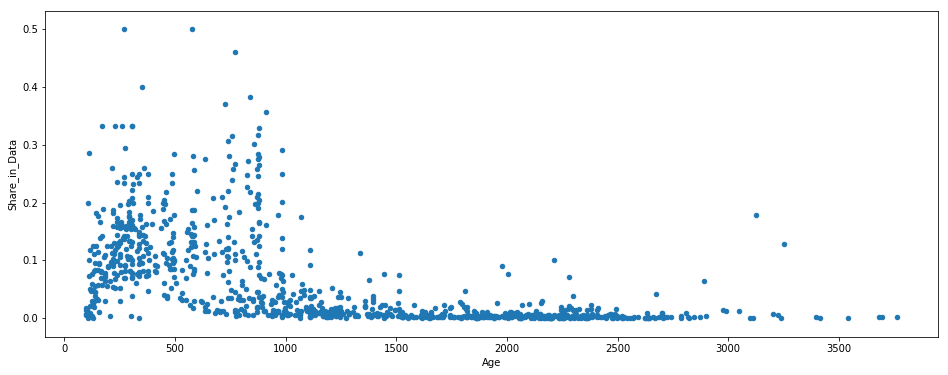

In [29]:
riders.plot.scatter('Age', 'Share_in_Data', figsize=(16, 6));

In [30]:
riders.sort_values('Age').head()

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Orders_per_Day,Ratings_per_Order,Orders_in_Data,Share_in_Data
957,Rider_Id_270,338,96,14.4,41,3.520833,0.121302,2,0.005917
958,Rider_Id_201,159,96,15.0,9,1.656250,0.056604,1,0.006289
955,Rider_Id_896,152,99,12.4,18,1.535354,0.118421,2,0.013158
953,Rider_Id_67,55,99,13.0,6,0.555556,0.109091,1,0.018182
956,Rider_Id_149,69,101,10.2,10,0.683168,0.144928,1,0.014493


**Видно, что для большинства 'Rider Id', даже недавно зарегистрированных доля отраженных в таблице заказов варьируется в широких пределах и не превышает 30%. 
Это должно снижать предсказательную силу различных статистик по 'Rider Id', посчитанных по данным таблицы заказов.**

In [31]:
data = data.merge(riders, on='Rider Id')

**Так как в данных нет точной информации о дне заказа, попытаемся оценить его (без использования внешних данных). Для этого введем новую переменную 'Week Lag', которая отражает на какой по счету день месяца приходится первый понедельник данного месяца.**

In [32]:
data['Week Lag'] = (data['Pickup - Day of Month'] - \
                    data['Pickup - Weekday (Mo = 1)']) % 7

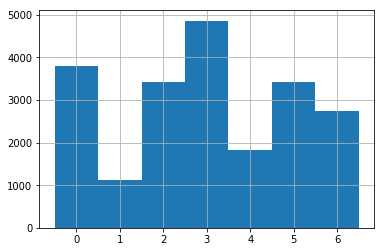

In [33]:
data.loc[data['Time from Pickup to Arrival'].notna(), 'Week Lag'].hist(bins=np.arange(-.5, 7, 1));

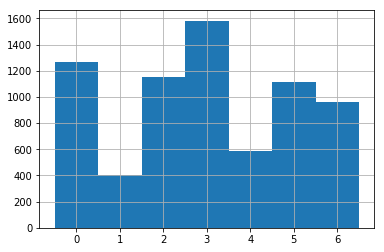

In [34]:
data.loc[data['Time from Pickup to Arrival'].isna(), 'Week Lag'].hist(bins=np.arange(-.5, 7, 1));

**Видно, что распределения совпадают для train и test. Значит они, скорее всего, относятся к одному и тому же периоду времени.**

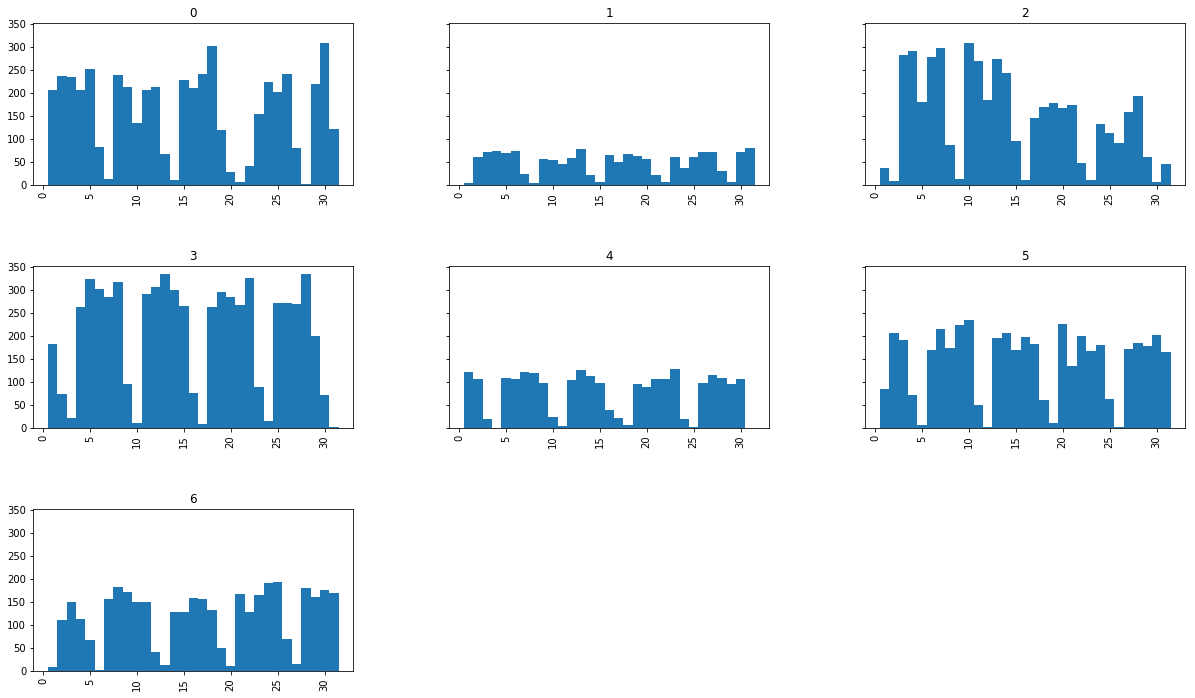

In [35]:
data.hist('Pickup - Day of Month', by='Week Lag', sharey=True,
          bins=np.arange(0.5, 32, 1), figsize=(20, 12));

**При этом распределение 'Week Lag' по месяцам за 2018 г. и первую половину 2019 г. должно быть такое:** 

**0-4-4--1-6-3--1-5-2--0-4-2----6-3-3--0-5-2** 

**Общий размер различных групп по этой переменной, говорит о том что данные, скорее всего охватывают период с 3-го квартала 2018 по 1-ый квартал 2019 года (предположительно, 2 первые недели июня 2019 г.). Тогда однозначно определяются только июль и ноябрь 2018 г. и январь 2019 г. В остальные категории попадают сразу несколько различных месяцев.**

**Поэтому, на всякий случай, добавим дамми-переменные для заказов из этих категорий по 'Week Lag', в которые температура значительно отличается в какую-то сторону от средней для данного дня месяца.**

In [36]:
h = 1
data['T Median'] = data.groupby([data['Pickup - Day of Month'], data['Placement Hour'] // h])['Temperature'] \
                       .transform(np.mean)

In [37]:
data['T Delta'] = (data['Temperature'] - data['T Median']).fillna(0)

In [38]:
for i in (0, 2, 5):
    data['Low T' + str(i)] = ((data['T Delta'] < 1.5) & (data['Week Lag'] == i)).astype('int8')

data['High T3'] = ((data['T Delta'] > .5) & (data['Week Lag'] == 3)).astype('int8')

In [39]:
del (data['T Median'], data['T Delta'])

**Заполним пропуски в данных о температуре медианной температурой для часа размещения заказа. Данные об осадках превратим в дамми-переменную.**

In [40]:
data['Temperature'].fillna(data.groupby('Placement Hour')['Temperature'].transform('median'), inplace=True)

In [41]:
data['Precipitation in millimeters'] = data['Precipitation in millimeters'].notna().astype('int8')

In [42]:
del data['Placement Hour']

**Посчитаем географическое расстояние между Pickup и Arrival.**

In [43]:
def geopy_distance(row):
    orig = (row["Pickup Lat"], row["Pickup Long"])
    dest = (row["Destination Lat"], row["Destination Long"])
    return distance.distance(orig, dest).km

In [44]:
data['Geopy Distance'] = data.apply(geopy_distance, axis=1)

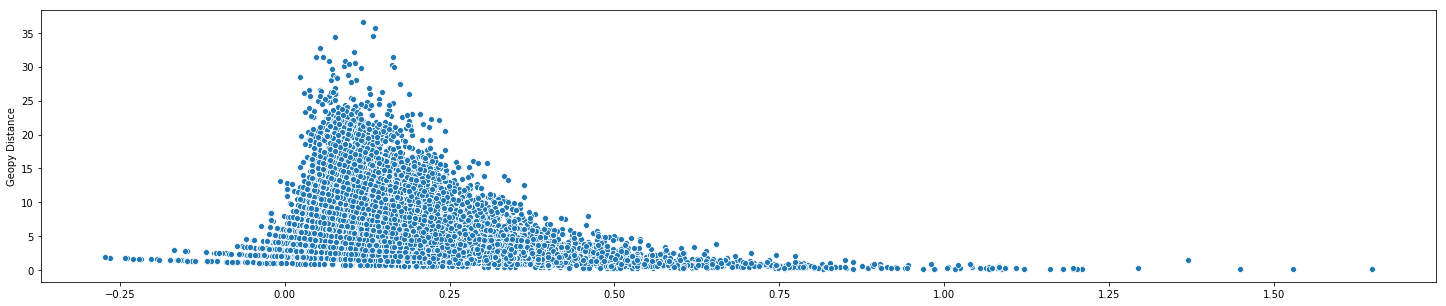

In [45]:
plt.figure(figsize=(25,5))
sns.scatterplot(np.log10(data['Distance (KM)']/data['Geopy Distance']), data['Geopy Distance']);

**Видно бывает разница, в т.ч. когда указанное расстояние меньше географического. Поэтому для нелинейной модели может быть полезна переменная с этой разницей.**

In [46]:
data['Distance Diff'] = data['Distance (KM)'] - data['Geopy Distance']

**Вообще связь между расстоянием и временем доставки на графиках не сильно выражена.** 

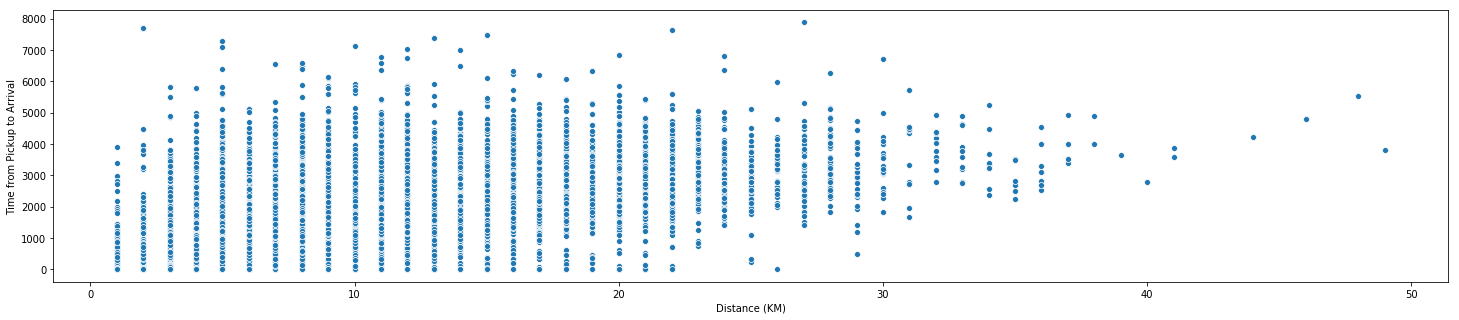

In [47]:
plt.figure(figsize=(25,5))
sns.scatterplot(data['Distance (KM)'], data['Time from Pickup to Arrival']);

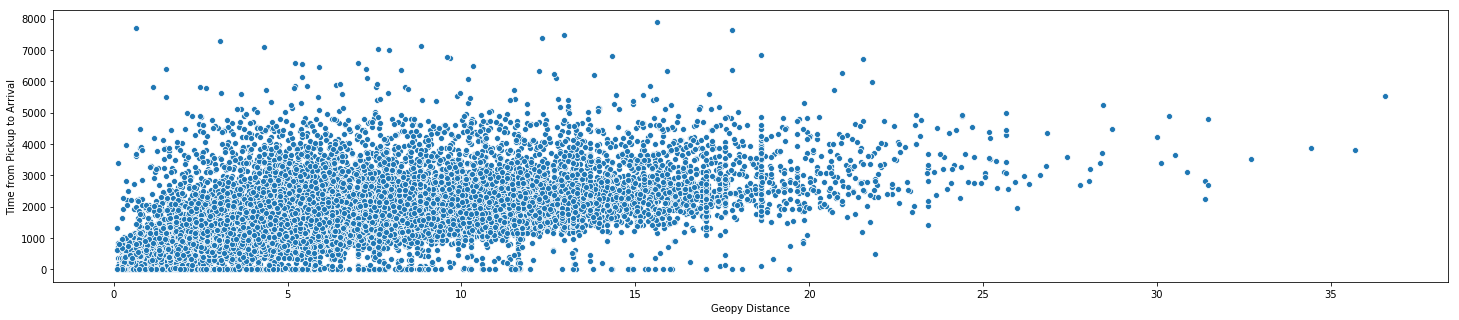

In [48]:
plt.figure(figsize=(25,5))
sns.scatterplot(data['Geopy Distance'], data['Time from Pickup to Arrival']);

**Посчитаем географическое направление из Pickup в Arrival.**

In [49]:
def bearing(lat1, lon1, lat2, lon2):
    for c in (lat1, lon1, lat2, lon2):
        c = np.radians(c)
    dLon = lon2 - lon1
    y = np.sin(dLon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dLon);
    return np.degrees(np.arctan2(y, x)).astype('int16')

In [50]:
cols = ['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long']

In [51]:
data['Bearing'] = bearing(*[data[c] for c in cols])

**Теперь добавим внешние данные от Uber о времени передвижения в Найроби между выделенными кластерами.  Все эти данные можно свободно скачать по [ссылке](https://movement.uber.com/cities/nairobi/downloads/speeds?lang=en-US&tp[y]=2019&tp[q]=1). При этом постараемся учесть данные о времени из переменной 'Week Lag'. Из-за этого далее будет много повторяющихся строчек.**

In [52]:
import json
from shapely.geometry import Point, Polygon

uber_polygons = {}
with open('Data/nairobi_hexclusters.json') as json_file:
    map_data = json.load(json_file)  
    for result in map_data['features']:
        movement_id = int(result[u'properties'][u'MOVEMENT_ID'])
        poly = result[u'geometry'][u'coordinates'][0]
        uber_polygons[movement_id] = Polygon(poly)

In [53]:
len(uber_polygons)

400

In [54]:
dcache = {}
def which_polygone(coordinates, uber_geometry=uber_polygons):
    dists = np.ones(max(uber_geometry.keys()) + 1)*100
    if coordinates in dcache:
        return dcache[coordinates]
    else:
        point = Point(coordinates)
        for uber_id, poly in uber_geometry.items():       
            if point.within(poly):
                dcache[coordinates] = uber_id
                return uber_id
            else:
                dists[uber_id] = poly.distance(point)
        i = dists.argmin()
        dcache[coordinates] = i
        return i

In [55]:
data['Pickup Id'] = list(map(which_polygone, 
                             zip(data['Pickup Long'].values, data['Pickup Lat'].values)))

In [56]:
data['Destination Id'] = list(map(which_polygone,
                                  zip(data['Destination Long'].values, data['Destination Lat'].values)))

In [57]:
data['Pickup Id'] = data['Pickup Id'].astype('int16')
data['Destination Id'] = data['Destination Id'].astype('int16')

In [58]:
h = 1
d = data[['Order No', 'Pickup Id', 'Destination Id', 'Pickup - Weekday (Mo = 1)', 'Week Lag']].copy()
d['Weekend'] = (data['Pickup - Weekday (Mo = 1)'] > 5).astype('int8')
d['hod'] = data['Pickup - Time'].astype('int8') // h

In [59]:
data_path = 'Data/'

In [60]:
q2y2018WeHourly = pd.read_csv(data_path+'nairobi-hexclusters-2018-2-OnlyWeekends-HourlyAggregate.csv', 
                             usecols=range(5))
q2y2018WdHourly = pd.read_csv(data_path+'nairobi-hexclusters-2018-2-OnlyWeekdays-HourlyAggregate.csv', 
                              usecols=range(5))
q2y2018Weekly = pd.read_csv(data_path+'nairobi-hexclusters-2018-2-WeeklyAggregate.csv', 
                            usecols=range(5))

q3y2018WeHourly = pd.read_csv(data_path+'nairobi-hexclusters-2018-3-OnlyWeekends-HourlyAggregate.csv', 
                             usecols=range(5))
q3y2018WdHourly = pd.read_csv(data_path+'nairobi-hexclusters-2018-3-OnlyWeekdays-HourlyAggregate.csv', 
                              usecols=range(5))
q3y2018Weekly = pd.read_csv(data_path+'nairobi-hexclusters-2018-3-WeeklyAggregate.csv', 
                            usecols=range(5))

q4y2018WeHourly = pd.read_csv(data_path+'nairobi-hexclusters-2018-4-OnlyWeekends-HourlyAggregate.csv', 
                              usecols=range(5))
q4y2018WdHourly = pd.read_csv(data_path+'nairobi-hexclusters-2018-4-OnlyWeekdays-HourlyAggregate.csv', 
                              usecols=range(5))
q4y2018Weekly = pd.read_csv(data_path+'nairobi-hexclusters-2018-4-WeeklyAggregate.csv', 
                            usecols=range(5))

q1y2019WeHourly = pd.read_csv(data_path+'nairobi-hexclusters-2019-1-OnlyWeekends-HourlyAggregate.csv', 
                             usecols=range(5))
q1y2019WdHourly = pd.read_csv(data_path+'nairobi-hexclusters-2019-1-OnlyWeekdays-HourlyAggregate.csv', 
                             usecols=range(5))
q1y2019Weekly = pd.read_csv(data_path+'nairobi-hexclusters-2019-1-WeeklyAggregate.csv', 
                             usecols=range(5))

q2y2019WeHourly = pd.read_csv(data_path+'nairobi-hexclusters-2019-2-OnlyWeekends-HourlyAggregate.csv', 
                              usecols=range(5))
q2y2019WdHourly = pd.read_csv(data_path+'nairobi-hexclusters-2019-2-OnlyWeekdays-HourlyAggregate.csv', 
                              usecols=range(5))
q2y2019Weekly = pd.read_csv(data_path+'nairobi-hexclusters-2019-2-WeeklyAggregate.csv', 
                            usecols=range(5))

In [61]:
q1y2019WeHourly['Weekend'] = 1
q1y2019WdHourly['Weekend'] = 0
q1y2019Hourly = q1y2019WdHourly.append(q1y2019WdHourly)
q2y2019WeHourly['Weekend'] = 1
q2y2019WdHourly['Weekend'] = 0
q2y2019Hourly = q2y2019WdHourly.append(q2y2019WdHourly)

q2y2018WeHourly['Weekend'] = 1
q2y2018WdHourly['Weekend'] = 0
q2y2018Hourly = q2y2018WdHourly.append(q2y2018WdHourly)
q3y2018WeHourly['Weekend'] = 1
q3y2018WdHourly['Weekend'] = 0
q3y2018Hourly = q3y2018WdHourly.append(q3y2018WdHourly)
q4y2018WeHourly['Weekend'] = 1
q4y2018WdHourly['Weekend'] = 0
q4y2018Hourly = q4y2018WdHourly.append(q4y2018WdHourly)

In [62]:
q1y2019Hourly['hod'] //= h
q1y2019Hourly = q1y2019Hourly.groupby(['sourceid', 'dstid', 'hod', 'Weekend']).mean()
q2y2019Hourly['hod'] //= h
q2y2019Hourly = q2y2019Hourly.groupby(['sourceid', 'dstid', 'hod', 'Weekend']).mean()
q2y2018Hourly['hod'] //= h
q2y2018Hourly = q2y2018Hourly.groupby(['sourceid', 'dstid', 'hod', 'Weekend']).mean()
q3y2018Hourly['hod'] //= h
q3y2018Hourly = q3y2018Hourly.groupby(['sourceid', 'dstid', 'hod', 'Weekend']).mean()
q4y2018Hourly['hod'] //= h
q4y2018Hourly = q4y2018Hourly.groupby(['sourceid', 'dstid', 'hod', 'Weekend']).mean()

In [63]:
q1y2019Hourly.head()

mean_travel_time  standard_deviation_travel_time
sourceid dstid hod Weekend                                                  
1        4     0   0                  226.83                          235.52
               4   0                  491.40                          608.59
               6   0                  448.33                          250.06
               7   0                  356.89                          212.93
               8   0                  353.44                          352.80

In [64]:
all_hourly = pd.concat([q2y2018Hourly, q3y2018Hourly, q4y2018Hourly, 
                        q1y2019Hourly, q2y2019Hourly]).groupby(level=(0,1,2,3)).mean()

In [65]:
all_hourly.index.rename(['Pickup Id', 'Destination Id', 'hod', 'Weekend'], inplace=True)

In [66]:
all_weekly = pd.concat([q2y2018Weekly, q3y2018Weekly, q4y2018Weekly, 
                        q1y2019Weekly, q2y2019Weekly]).groupby(['sourceid', 'dstid', 'dow']).mean()

In [67]:
all_weekly.index.rename(['Pickup Id', 'Destination Id', 'Pickup - Weekday (Mo = 1)'], inplace=True)

In [68]:
def fill(df, typ='hourly'):
    for c in ('mean_travel_time','standard_deviation_travel_time'):
        ind = df[c].isnull()
        if ind.any():
            if typ == 'hourly':
                big = all_hourly
                cols = ['Pickup Id', 'Destination Id', 'hod', 'Weekend']
            else:
                big = all_weekly
                cols = ['Pickup Id', 'Destination Id', 'Pickup - Weekday (Mo = 1)']
            s = df.loc[ind, cols].merge(big[c], right_index=True, left_on=cols)[c]
            df[c] = df[c].fillna(s)
        ind = df[c].isnull()
        if ind.any():
            cols = ['Pickup Id', 'Destination Id']
            s = big.groupby(cols)[c].agg('mean')
            s = df.loc[ind, cols].merge(s, right_index=True, left_on=cols)[c]
            df[c] = df[c].fillna(s)
            df[c].fillna(df[c].mean(), inplace=True)

In [69]:
data_wl36 = \
d.loc[d['Week Lag'].isin([3, 6]), :].merge(q1y2019Hourly, 
                                           how='left', 
                                           left_on=['Pickup Id', 'Destination Id', 'hod', 'Weekend'],
                                           right_on=['sourceid', 'dstid', 'hod', 'Weekend']
                                           )

In [70]:
fill(data_wl36)

In [71]:
hourly_names = {'mean_travel_time': 'Hourly Mean','standard_deviation_travel_time': 'Hourly Std'}
weekly_names = {'mean_travel_time': 'Weekday Mean','standard_deviation_travel_time': 'Weekday Std'}

In [72]:
data_wl36 = data_wl36.rename(hourly_names, axis=1)

In [73]:
data_wl36 = data_wl36.merge(q1y2019Weekly.set_index(['sourceid', 'dstid', 'dow']), how='left', 
                            left_on=['Pickup Id', 'Destination Id', 'Pickup - Weekday (Mo = 1)'],
                            right_index=True)

In [74]:
fill(data_wl36, 'weekly')

In [75]:
data_wl36 = data_wl36.rename(weekly_names, axis=1)

In [76]:
data_wl1 = \
d.loc[d['Week Lag']==1, :].merge(q3y2018Hourly, 
                                 how='left', 
                                 left_on=['Pickup Id', 'Destination Id', 'hod', 'Weekend'],
                                 right_on=['sourceid', 'dstid', 'hod', 'Weekend']
                                 )

In [77]:
fill(data_wl1)

In [78]:
data_wl1 = data_wl1.rename(hourly_names, axis=1)

In [79]:
data_wl1 = data_wl1.merge(q3y2018Weekly.set_index(['sourceid', 'dstid', 'dow']), how='left', 
                          left_on=['Pickup Id', 'Destination Id', 'Pickup - Weekday (Mo = 1)'],
                          right_index=True
                         )

In [80]:
fill(data_wl1, 'weekly')

In [81]:
data_wl1 = data_wl1.rename(weekly_names, axis=1)

In [82]:
data_wl4 = \
d.loc[d['Week Lag']==4, :].merge(q4y2018Hourly, 
                                 how='left', 
                                 left_on=['Pickup Id', 'Destination Id', 'hod', 'Weekend'],
                                 right_on=['sourceid', 'dstid', 'hod', 'Weekend']
                                 )
fill(data_wl4)
data_wl4 = data_wl4.rename(hourly_names, axis=1)
data_wl4 = data_wl4.merge(q4y2018Weekly.set_index(['sourceid', 'dstid', 'dow']), how='left', 
                          left_on=['Pickup Id', 'Destination Id', 'Pickup - Weekday (Mo = 1)'],
                          right_index=True
                         )
fill(data_wl4, 'weekly')
data_wl4 = data_wl4.rename(weekly_names, axis=1)

In [83]:
wl0Hourly = q4y2018Hourly.append(q2y2019Hourly)\
                         .groupby(['sourceid', 'dstid', 'hod', 'Weekend']).mean()
wl0Weekly = q4y2018Weekly.append(q2y2019Weekly)\
                         .groupby(['sourceid', 'dstid', 'dow']).mean()

In [84]:
data_wl0 = \
d.loc[d['Week Lag']==0, :].merge(wl0Hourly, 
                                 how='left', 
                                 left_on=['Pickup Id', 'Destination Id', 'hod', 'Weekend'],
                                 right_on=['sourceid', 'dstid', 'hod', 'Weekend']
                                 )
fill(data_wl0)
data_wl0 = data_wl0.rename(hourly_names, axis=1)
data_wl0 = data_wl0.merge(wl0Weekly, how='left', 
                          left_on=['Pickup Id', 'Destination Id', 'Pickup - Weekday (Mo = 1)'],
                          right_index=True
                         )
fill(data_wl0, 'weekly')
data_wl0 = data_wl0.rename(weekly_names, axis=1)

In [85]:
wl5Hourly = q3y2018Hourly.append(q2y2019Hourly)\
                         .groupby(['sourceid', 'dstid', 'hod', 'Weekend']).mean()
wl5Weekly = q3y2018Weekly.append(q2y2019Weekly)\
                         .groupby(['sourceid', 'dstid', 'dow']).mean()

In [86]:
data_wl5 = \
d.loc[d['Week Lag']==5, :].merge(wl5Hourly, 
                                 how='left', 
                                 left_on=['Pickup Id', 'Destination Id', 'hod', 'Weekend'],
                                 right_on=['sourceid', 'dstid', 'hod', 'Weekend']
                                 )
fill(data_wl5)
data_wl5 = data_wl5.rename(hourly_names, axis=1)
data_wl5 = data_wl5.merge(wl5Weekly, how='left', 
                          left_on=['Pickup Id', 'Destination Id', 'Pickup - Weekday (Mo = 1)'],
                          right_index=True
                         )
fill(data_wl5, 'weekly')
data_wl5 = data_wl5.rename(weekly_names, axis=1)

In [87]:
wl2Hourly = pd.concat([q3y2018Hourly, q4y2018Hourly, q2y2019Hourly])\
                         .groupby(['sourceid', 'dstid', 'hod', 'Weekend']).mean()
wl2Weekly = pd.concat([q3y2018Weekly, q4y2018Weekly, q2y2019Weekly])\
                         .groupby(['sourceid', 'dstid', 'dow']).mean()

In [88]:
data_wl2 = \
d.loc[d['Week Lag']==2, :].merge(wl2Hourly, 
                                 how='left', 
                                 left_on=['Pickup Id', 'Destination Id', 'hod', 'Weekend'],
                                 right_on=['sourceid', 'dstid', 'hod', 'Weekend']
                                 )
fill(data_wl2)
data_wl2 = data_wl2.rename(hourly_names, axis=1)
data_wl2 = data_wl2.merge(wl2Weekly, how='left', 
                          left_on=['Pickup Id', 'Destination Id', 'Pickup - Weekday (Mo = 1)'],
                          right_index=True
                         )
fill(data_wl2, 'weekly')
data_wl2 = data_wl2.rename(weekly_names, axis=1)

In [89]:
cols = ['Order No', 'Hourly Mean', 'Hourly Std', 'Weekday Mean', 'Weekday Std']
d = pd.concat([data_wl0[cols], data_wl1[cols], 
               data_wl2[cols], data_wl36[cols], 
               data_wl4[cols], data_wl5[cols]])

In [90]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28269 entries, 0 to 4543
Data columns (total 5 columns):
Order No        28269 non-null object
Hourly Mean     28269 non-null float64
Hourly Std      28269 non-null float64
Weekday Mean    28269 non-null float64
Weekday Std     28269 non-null float64
dtypes: float64(4), object(1)
memory usage: 1.3+ MB


In [91]:
data = data.merge(d, on='Order No', how='left')

**Видим, что корреляция целевой переменной с данными Uber достаточно высока.**

In [92]:
data[['Time from Pickup to Arrival', 'Hourly Mean', 'Weekday Mean', 'Distance (KM)']].corr()

,Time from Pickup to Arrival,Hourly Mean,Weekday Mean,Distance (KM)
Time from Pickup to Arrival,1.000000,0.509089,0.542716,0.580608
Hourly Mean,0.509089,1.000000,0.903559,0.711968
Weekday Mean,0.542716,0.903559,1.000000,0.787398
Distance (KM),0.580608,0.711968,0.787398,1.000000


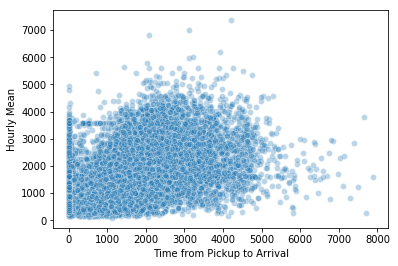

In [93]:
sns.scatterplot(data['Time from Pickup to Arrival'], data['Hourly Mean'], alpha=.3);

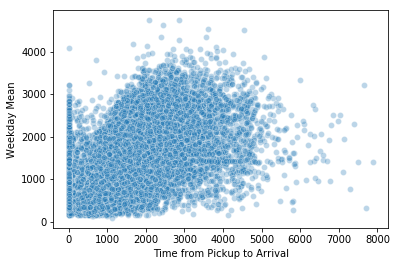

In [94]:
sns.scatterplot(data['Time from Pickup to Arrival'], data['Weekday Mean'], alpha=.3);

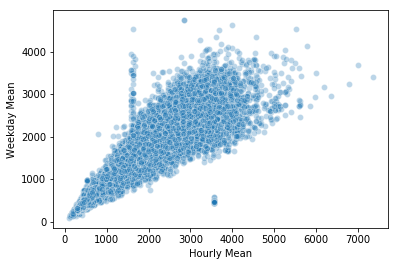

In [95]:
sns.scatterplot(x=data['Hourly Mean'], y=data['Weekday Mean'], alpha=.3);

**Добавим данные о скорости.**

In [96]:
data['Speed'] = np.maximum(data['Distance (KM)'], data['Geopy Distance']) / data['Time from Pickup to Arrival'] * 3600

In [97]:
data['Uber Speed'] = np.maximum(data['Distance (KM)'], data['Geopy Distance']) /\
                     (data['Weekday Mean']*data['Hourly Mean'])**.5 * 3600

In [98]:
data['Speed'].describe()

count    21201.000000
mean       249.983322
std       1906.895071
min          0.920245
25%         16.494845
50%         23.076923
75%         30.296378
max      61200.000000
Name: Speed, dtype: float64

In [99]:
data['Uber Speed'].describe()

count    28269.000000
mean        24.558895
std         12.828119
min          2.336096
25%         17.192973
50%         21.706625
75%         28.293694
max        636.381270
Name: Uber Speed, dtype: float64

**Видно, что выбросы есть даже в данных Uber.**

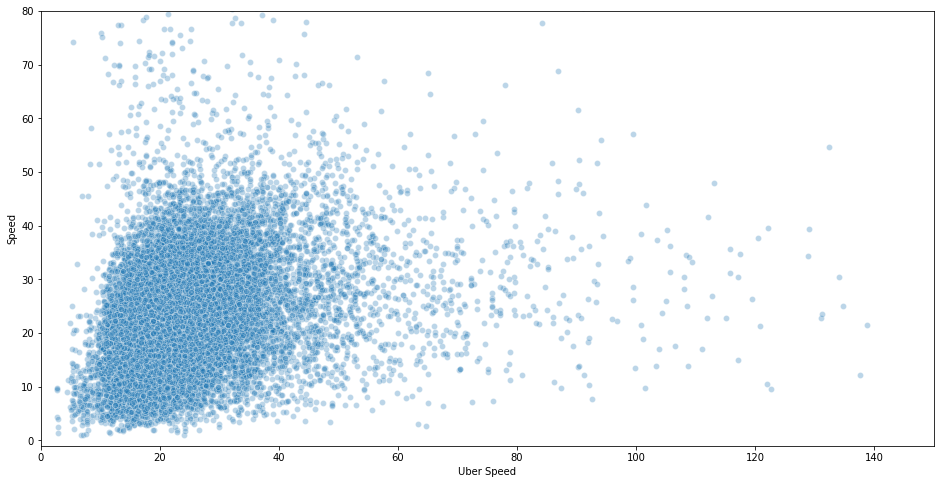

In [100]:
plt.figure(figsize=(16, 8))
sns.scatterplot(data['Uber Speed'], data['Speed'], alpha=.3);
plt.xlim((0,150))
plt.ylim((-1,80));

**Добавим кластеры точек Pickup и Arrival, сделанные с помощью модели KMeans.**

In [148]:
# coords = pd.DataFrame(np.vstack([data[['Destination Id', 'Destination Lat', 'Destination Long']].values,
#                                  data[['Pickup Id', 'Pickup Lat', 'Pickup Long']].values]), 
#                       columns=['Id', 'Lat', 'Long'])

In [149]:
# coords['Id'] = coords['Id'].astype('uint16')
# coords['Weight'] = 1

In [161]:
# cntr_coords = coords.groupby('Id').agg({'Lat':'mean', 'Long':'mean', 'Weight':'sum'})

In [243]:
# km = KMeans(n_clusters=45, random_state=0, n_jobs=-1, n_init=60)
# km.fit(cntr_coords.iloc[:, :2], sample_weight=cntr_coords['Weight'])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=45, n_init=60, n_jobs=-1, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [244]:
# cntr_coords['Id_2'] = km.predict(cntr_coords.iloc[:, :2])

In [245]:
# data['Destination Id_2'] = data['Destination Id'].map(cntr_coords['Id_2'])
# data['Pickup Id_2'] = data['Pickup Id'].map(cntr_coords['Id_2'])

In [101]:
coords = np.vstack([data[['Destination Lat', 'Destination Long']].values,
                              data[['Pickup Lat', 'Pickup Long']].values])

In [102]:
km = KMeans(n_clusters=40, random_state=0, n_jobs=-1, n_init=20)
km.fit(coords)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=40, n_init=20, n_jobs=-1, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [103]:
data['Destination Id_2'] = km.predict(data[['Destination Lat', 'Destination Long']])
data['Pickup Id_2'] = km.predict(data[['Pickup Lat', 'Pickup Long']])

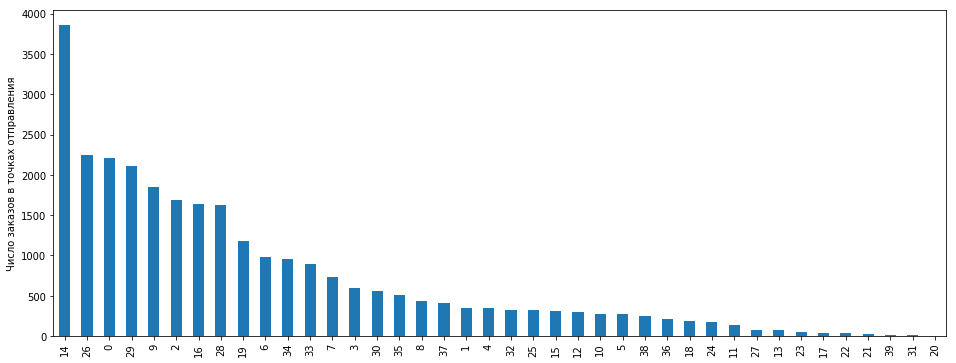

In [104]:
data['Pickup Id_2'].value_counts().plot.bar(figsize=(16, 6))
plt.ylabel('Число заказов в точках отправления');

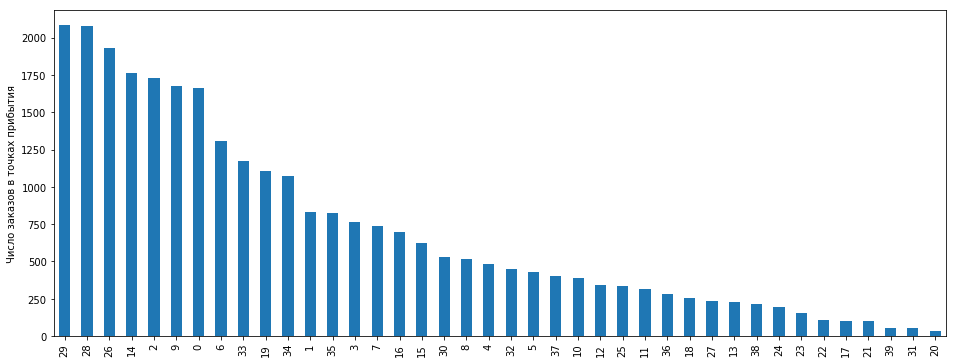

In [105]:
data['Destination Id_2'].value_counts().plot.bar(figsize=(16, 6))
plt.ylabel('Число заказов в точках прибытия');

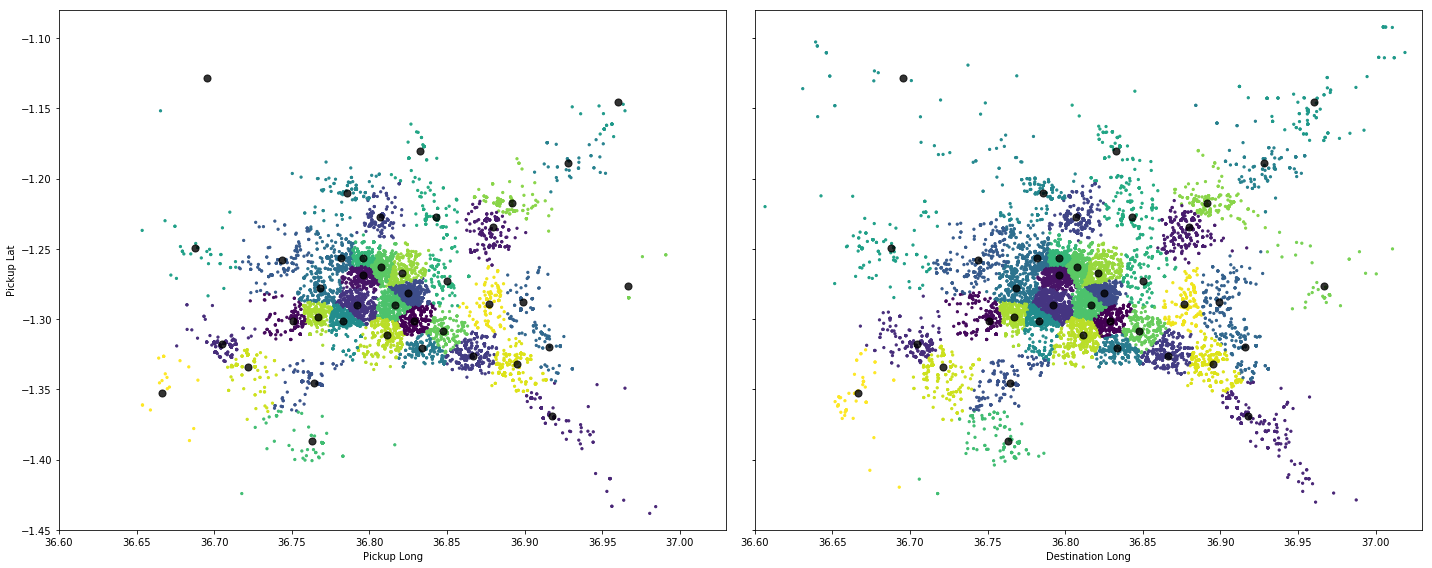

In [106]:
city_long_border = (36.6, 37.03)
city_lat_border = (-1.45, -1.08)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

data.plot.scatter(x='Pickup Long', y='Pickup Lat', sharey=True,
               ylim=city_lat_border, xlim=city_long_border, ax=ax[0],
               c=data['Pickup Id_2'], s=5, cmap='viridis', colorbar=False)
ax[0].scatter(km.cluster_centers_[:, 1], km.cluster_centers_[:, 0], 
              c='black', s=50, alpha=0.8)

data.plot.scatter(x='Destination Long', y='Destination Lat',
               ylim=city_lat_border, xlim=city_long_border, ax=ax[1],
               c=data['Destination Id_2'], s=5, cmap='viridis', colorbar=False)
ax[1].scatter(km.cluster_centers_[:, 1], km.cluster_centers_[:, 0], 
              c='black', s=50, alpha=0.8)

plt.tight_layout();

**Добавим категориальную переменную "связи" между полученными кластерами. А также посчитаем некоторые статистики по этой переменной.**

In [107]:
def make_link(row):
    a, b = row['Pickup Id_2'], row['Destination Id_2']
    return f'{a}-{b}' if a <= b else f'{b}-{a}'

In [108]:
data['Link Id'] = data.apply(make_link, axis=1)

In [109]:
data['Link Id'] = data['Link Id'].astype('category')

In [110]:
data['Link Id'].nunique()

697

In [111]:
data['Link Distance Mean'] = data.groupby('Link Id')['Distance (KM)'].transform('mean')

In [112]:
data['Link Distance Std'] = data.groupby('Link Id')['Distance (KM)'].transform('std').fillna(0) 

In [113]:
data['Link Geopy-to-Dist Std'] = (data['Geopy Distance']/data['Distance (KM)']).groupby(data['Link Id'])\
                                                                               .transform('std').fillna(0)

In [114]:
for col in ['Rider Id', 'User Id', 'Platform Type', 
            'Week Lag', 'Pickup Id', 'Destination Id', 
            'Pickup Id_2', 'Destination Id_2']:
    data[col] = data[col].astype('category')

In [115]:
data['Personal or Business'] = data['Personal or Business'].astype('category').cat.codes

In [116]:
data.to_pickle('Data/data.pkl')

## Modeling

In [2]:
data = pd.read_pickle('Data/data.pkl')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28269 entries, 0 to 28268
Data columns (total 49 columns):
Order No                        28269 non-null object
User Id                         28269 non-null category
Platform Type                   28269 non-null category
Personal or Business            28269 non-null int8
Pickup - Day of Month           28269 non-null int16
Pickup - Weekday (Mo = 1)       28269 non-null int16
Pickup - Time                   28269 non-null float64
Distance (KM)                   28269 non-null int16
Temperature                     28269 non-null float64
Precipitation in millimeters    28269 non-null int8
Pickup Lat                      28269 non-null float64
Pickup Long                     28269 non-null float64
Destination Lat                 28269 non-null float64
Destination Long                28269 non-null float64
Rider Id                        28269 non-null category
Time from Pickup to Arrival     21201 non-null float64
Confirmation Delay   

**Для использования в модели, немного изменим существующие и посчитаем некоторые дополнительные фичи:**

In [4]:
data['Bearing'] = data['Bearing'].astype('category')

**- фичи, относящиеся к 'Rider Id'**

In [5]:
# географическое растояние с учетом "опыта" доставщика
data['Geopy Exp Distance'] = data['Geopy Distance'] / np.log1p(data['No_Of_Orders'])

data['Average Distance'] = data.groupby('Rider Id')['Distance (KM)'].transform('mean')
data['Relative Distance'] = data['Distance (KM)'] / data['Average Distance']

# Важные характеристики для определения случаев, когда 'Rider Id' не вовремя вносит информацию о времени
data['Pickup Delay Mean'] = data.groupby('Rider Id')['Pickup Delay'].transform('mean')
data['Pickup Relative Delay'] = data['Pickup Delay'] / data['Pickup Delay Mean']
data['Total Delay'] = data['Arrival Delay'] + data['Pickup Delay']

**- фичи, относящиеся к данным Uber**

In [6]:
data['Mean Average'] = (data['Hourly Mean'] * data['Weekday Mean'])**.5
data['Average Std'] = (data['Hourly Std'] * data['Weekday Std'])**.5
data['Average Var Coef'] = data['Average Std'] / data['Mean Average']
data.drop(['Hourly Mean', 'Weekday Mean', 'Hourly Std', 'Weekday Std', 'Orders_per_Day'], axis=1, inplace=True)

In [7]:
data.to_pickle('Data/data_2.pkl')

**Валидация на отложенном датасете в демонстрационных целях.**

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from catboost import CatBoostRegressor, CatBoostClassifier

In [9]:
df = data.loc[data['Time from Pickup to Arrival'].notna(), :].copy()
riders_in_train = df.groupby('Rider Id')['Rider Id'].count()
df['Orders_in_Data'] = df['Rider Id'].map(riders_in_train).fillna(0).astype('int16')
df['Share_in_Data'] = df['Orders_in_Data'] / df['No_Of_Orders']

y, pkp = df['Time from Pickup to Arrival'], df['Pickup Delay']
y_share = y / (y + pkp)
df = df.drop(['Order No', 'Time from Pickup to Arrival'], axis=1)

**В зависимости от random_state могут выбираться совершенно разные разбиения данных, на которых RSME моделей будет варьироваться от 660 до 780 секунд. Это создавало большие проблемы на кросс-валидации. В этом ноутбуке попытаемся подобрать разбиение, ошибка на котором более-менее соответствует результататм на Public/Private Leaderboard. Для этого воспользуемся дополнительной стратификацией по 'Week Lag' и 'Rider Id'.**

In [10]:
train_ind, val_ind = train_test_split(df.index, random_state=2019, test_size=.1, 
                                      stratify=df['Rider Id'].str[-3:-2].str.cat(df['Week Lag'].apply(str)))

**Добавим признаков, сгенерированных для 'Rider Id' и 'Link Id' на основе целевой переменной.**

In [11]:
train, valid = df.loc[train_ind, :].copy(), df.loc[val_ind, :].copy()
y_train, y_valid = y.loc[train_ind], y.loc[val_ind]

# Это доля времени от "Arrival to Pickup" до "Arrival to Destination", 
# которя приходится непосредственно на целевую переменную.
y_s = y_share.loc[train_ind]

# На основе ее значений на train сгенерированы mean-encoded переменные для 'Raider Id'
for i in range(3):
    bad_share = (y_s < .45 + .2*i).groupby(train['Rider Id']).mean()
    train[f'Rider Bad Share {i}'] = train['Rider Id'].map(bad_share)
    valid[f'Rider Bad Share {i}'] = valid['Rider Id'].map(bad_share).fillna(bad_share.median())

col, alpha = 'Rider Id', 200
f_share = y_s.groupby(train[col]).agg('sum') + alpha*y_s.mean()
f_share /= y_s.groupby(train[col]).agg('count') + alpha
train[f'{col[:-3]} Share Mean'] = train[col].map(f_share).astype('float64')
valid[f'{col[:-3]} Share Mean'] = valid[col].map(f_share).astype('float64') \
                                            .fillna(y_s.mean())

    
# На основе значений скорости на train посчитаны mean-encoded переменные для 'Raider Id' и 'Link Id'
bad_share = (train['Speed'] > 100).groupby(train['Rider Id']).mean()
train['Rider Bad Speed Share'] = train['Rider Id'].map(bad_share)
valid['Rider Bad Speed Share'] = valid['Rider Id'].map(bad_share).fillna(bad_share.median())

bad_share = (train['Speed'] < 12).groupby(train['Link Id']).mean()
train['Link Bad Speed Share'] = train['Link Id'].map(bad_share)
valid['Link Bad Speed Share'] = valid['Link Id'].map(bad_share).fillna(bad_share.median())

for col in ['Rider Id']:
    f = 'mad'
    grouper = train.groupby(col)['Speed']
    f_speed = grouper.agg(f).clip(upper=50)
    train[col[:-2]+'Speed '+f.title()] = train[col].map(f_speed).astype('float64')
    valid[col[:-2]+'Speed '+f.title()] = valid[col].map(f_speed).astype('float64') \
                                                   .fillna(f_speed.median())

**Помимо регрессии будет использоваться классификатор для поиска "неправильно введенного" времени поездки. Классификатор будет частью второй усредняемой модели. При этом некоторые mean-encoded переменные будут исключены из регрессии, некоторые - из классификации.**

In [13]:
clf_ex = ['Rider Speed Mad', 'Rider Bad Speed Share', 'Pickup - Time']
reg_ex = [f'Rider Bad Share {i}' for i in range(1,3)]

**Вероятности из классификатора, что время доставки в датасете адекватно (не является выбросом с оценочной скоростью более 85 км/ч) будут умножаться на ETA, посчитанное по данным с исключенными выбросами (скорость более 85 км/ч).**

In [14]:
train_good = train.loc[train['Speed']<=85, :].copy()

In [15]:
train_good.drop(['Speed']+reg_ex, axis=1, inplace=True)
train.drop(['Speed'], axis=1, inplace=True)
valid.drop(['Speed'], axis=1, inplace=True)

**Сначала обучим обычную регрессию на всей обучающей выборке. Это будет первая из усредняемых моделей.**

In [16]:
X = train.drop(reg_ex, axis=1)
reg1 = CatBoostRegressor(iterations=3400,
                         learning_rate=0.01,
                         depth=10,
                         one_hot_max_size=14,
                         verbose=200,
                         cat_features=X.columns[X.dtypes=='category'],
                        )

In [17]:
reg1.fit(X, y_train, 
         eval_set=(valid.drop(reg_ex, axis=1), y_valid),
         use_best_model=False,
        )
y_pred1 = reg1.predict(valid.drop(reg_ex, axis=1)).clip(1)

0:	learn: 983.5624203	test: 984.7745078	best: 984.7745078 (0)	total: 136ms	remaining: 7m 43s
200:	learn: 732.2701232	test: 753.0846645	best: 753.0846645 (200)	total: 16.3s	remaining: 4m 19s
400:	learn: 685.0310580	test: 732.0953223	best: 732.0953223 (400)	total: 33.6s	remaining: 4m 11s
600:	learn: 655.1391502	test: 726.2411036	best: 726.2408313 (599)	total: 52.8s	remaining: 4m 5s
800:	learn: 628.8627973	test: 722.8271842	best: 722.8271842 (800)	total: 1m 11s	remaining: 3m 50s
1000:	learn: 606.3234099	test: 721.0987180	best: 721.0811081 (999)	total: 1m 30s	remaining: 3m 37s
1200:	learn: 586.2282510	test: 719.7668504	best: 719.6700793 (1182)	total: 1m 48s	remaining: 3m 19s
1400:	learn: 567.3552246	test: 718.8462496	best: 718.8462496 (1400)	total: 2m 6s	remaining: 3m
1600:	learn: 551.1077752	test: 717.9008229	best: 717.8996656 (1599)	total: 2m 25s	remaining: 2m 43s
1800:	learn: 535.8407527	test: 717.3625961	best: 717.3196935 (1791)	total: 2m 45s	remaining: 2m 26s
2000:	learn: 519.6461490	

**Теперь обучим классификатор и регрессор для второй модели.**

In [18]:
reg2 = CatBoostRegressor(iterations=2200,
                         cat_features=train_good.columns[train_good.dtypes=='category'],
                         learning_rate=0.01,
                         depth=10,
                         one_hot_max_size=14,
                         verbose=200,
                        )

In [19]:
reg2.fit(train_good, y_train.loc[train_good.index], 
         eval_set=(valid.drop(reg_ex, axis=1), y_valid),
         use_best_model=False,
        )
y_pred2 = reg2.predict(valid.drop(reg_ex, axis=1))

0:	learn: 950.8420948	test: 988.6877642	best: 988.6877642 (0)	total: 75ms	remaining: 2m 44s
200:	learn: 716.5129460	test: 780.3145401	best: 780.3145401 (200)	total: 17s	remaining: 2m 49s
400:	learn: 669.6340483	test: 759.7490474	best: 759.7490474 (400)	total: 35.8s	remaining: 2m 40s
600:	learn: 639.2954436	test: 753.1906836	best: 753.1824867 (597)	total: 54s	remaining: 2m 23s
800:	learn: 614.2590739	test: 750.3105154	best: 750.2970056 (797)	total: 1m 12s	remaining: 2m 7s
1000:	learn: 591.7131570	test: 748.3252206	best: 748.3252206 (1000)	total: 1m 30s	remaining: 1m 48s
1200:	learn: 571.7573929	test: 747.4350274	best: 747.4350274 (1200)	total: 1m 48s	remaining: 1m 30s
1400:	learn: 554.5026792	test: 746.9068709	best: 746.9005469 (1386)	total: 2m 6s	remaining: 1m 12s
1600:	learn: 538.5824081	test: 746.4792786	best: 746.4223282 (1580)	total: 2m 26s	remaining: 54.7s
1800:	learn: 523.4647722	test: 746.1847068	best: 746.1338907 (1785)	total: 2m 44s	remaining: 36.4s
2000:	learn: 509.3375087	te

In [20]:
X = train.drop(clf_ex, axis=1)
cbC = CatBoostClassifier(iterations=1200,
                         eval_metric='AUC',
                         learning_rate=0.01,
                         depth=10,
                         one_hot_max_size=14,
                         l2_leaf_reg=3.5,
                         verbose=200,
                         cat_features=X.columns[X.dtypes=='category'],
                         )

In [21]:
s = (df['Speed'] > 85).astype('int8')
s_train, s_valid = s.loc[train_ind], s.loc[val_ind]

In [22]:
cbC.fit(X, s_train,
        cat_features=X.columns[X.dtypes=='category'],
        eval_set=(valid.drop(clf_ex, axis=1), s_valid),
        use_best_model=False,
       )

0:	test: 0.8233998	best: 0.8233998 (0)	total: 120ms	remaining: 2m 24s
200:	test: 0.9318741	best: 0.9320365 (181)	total: 22.3s	remaining: 1m 50s
400:	test: 0.9377999	best: 0.9377999 (400)	total: 45s	remaining: 1m 29s
600:	test: 0.9403104	best: 0.9404217 (595)	total: 1m 8s	remaining: 1m 8s
800:	test: 0.9409090	best: 0.9409739 (767)	total: 1m 30s	remaining: 45s
1000:	test: 0.9412848	best: 0.9414241 (935)	total: 1m 51s	remaining: 22.2s
1199:	test: 0.9415029	best: 0.9415076 (1095)	total: 2m 12s	remaining: 0us

bestTest = 0.9415075778
bestIteration = 1095



**Вероятности того, что скорость неправильная.**

In [23]:
p = cbC.predict_proba(valid.drop(clf_ex, axis=1))[:, 1]

**Комбиниравоное предсказание второй модели.**

In [24]:
y_pred3 = (y_pred2 * (1-p)).clip(1)

**RMSE на валидации для первой модели.**

In [25]:
np.sqrt(mean_squared_error(y_valid,  y_pred1))

715.7347389119708

**RMSE на валидации для второй модели.**

In [26]:
np.sqrt(mean_squared_error(y_valid,  y_pred3))

716.4737032061032

**Посчитаем веса для усреднения двух моделей.**

In [27]:
a = (y_pred1 - y_pred3).dot(y_pred1 - y_valid) / (y_pred1 - y_pred3).dot(y_pred1 - y_pred3)
a

0.43245501210319065

**RMSE на валидации для усредненного предсказания.**

In [28]:
np.sqrt(mean_squared_error(y_valid,  a*y_pred2*(1-p) + (1-a)*y_pred1))

714.7104624222911

**Наиболее значимые факторы для классификации и регрессии во второй модели.**

In [29]:
def imps_plot(imps, title, ax=None):
    plt.figure(figsize=(16, 8))
    sns.barplot(x='Importances', y='Feature Id', data=imps, orient='h', 
                color='royalblue', ax=ax) \
       .set_title(title, fontsize=13)

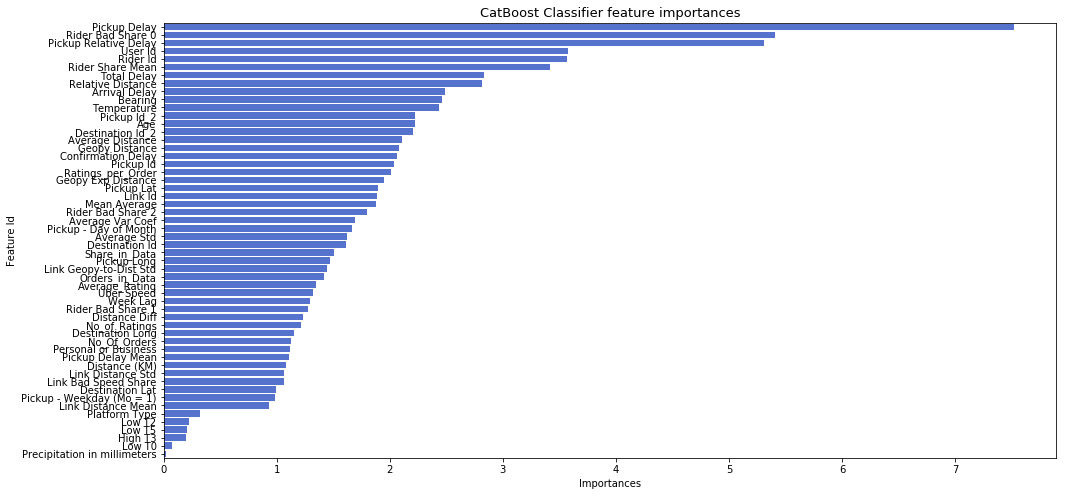

In [30]:
imps_plot(cbC.get_feature_importance(prettified=True), "CatBoost Classifier feature importances")    
plt.show()

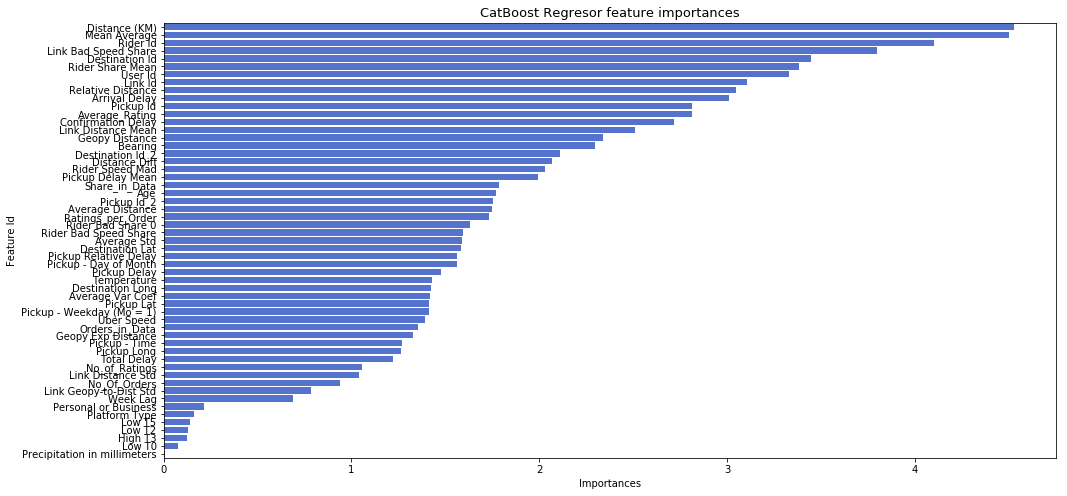

In [31]:
imps_plot(reg2.get_feature_importance(prettified=True), "CatBoost Regresor feature importances")    
plt.show()

**Графики ошибок предсказания на валидации в зависимости от значений целевой переменной. Предсказания моделей выглядят высоко скорелированными.**

In [32]:
errors1 = (y_valid - y_pred1).rename('Validation Error for the First Model')
errors3 = (y_valid - y_pred3).rename('Validation Error for the Second Model')

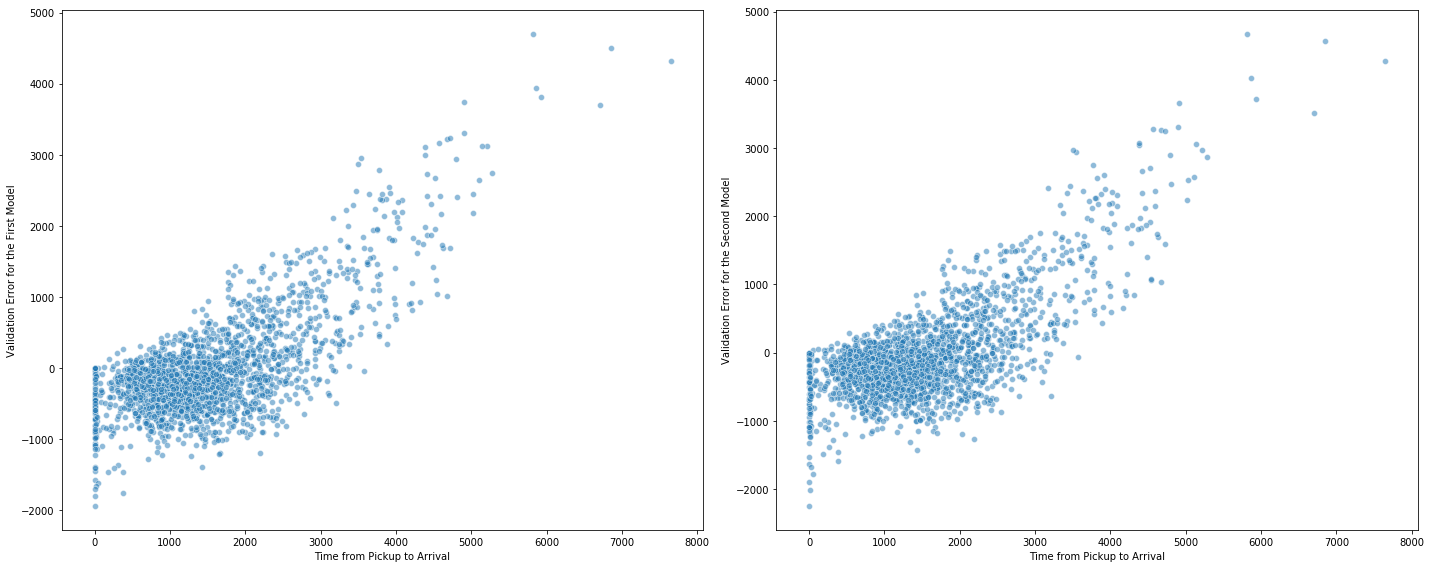

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharex=True)
sns.scatterplot(y_valid, errors1, ax=ax[0], alpha=.5)
sns.scatterplot(y_valid, errors3, ax=ax[1], alpha=.5)
plt.tight_layout();

**Посчитаем теперь аналогичные предсказания для всей выборки.**

In [34]:
data, index = data.drop(['Order No'], axis=1), data['Order No']

In [35]:
train_ind = data['Time from Pickup to Arrival'].notna()
train, test = data.loc[train_ind, :],  data.loc[~train_ind, :]\
                                           .drop(['Time from Pickup to Arrival'], axis=1)
y = train['Time from Pickup to Arrival']
train = train.drop(['Time from Pickup to Arrival'], axis=1)

for i in range(3):
    bad_share = (y_share < .45 + .2*i).groupby(train['Rider Id']).mean()
    train[f'Rider Bad Share {i}'] = train['Rider Id'].map(bad_share)
    test[f'Rider Bad Share {i}'] = test['Rider Id'].map(bad_share).fillna(bad_share.median())

col, alpha = 'Rider Id', 200
f_share = y_share.groupby(train[col]).agg('sum') + alpha*y_share.mean()
f_share /= y_share.groupby(train[col]).agg('count') + alpha
train[col+' Share Mean'] = train[col].map(f_share).astype('float64')
test[col+' Share Mean'] = test[col].map(f_share).astype('float64') \
                                                .fillna(y_share.mean())
    
bad_share = (train['Speed'] > 100).groupby(train['Rider Id']).mean()
train['Rider Bad Speed Share'] = train['Rider Id'].map(bad_share)
test['Rider Bad Speed Share'] = test['Rider Id'].map(bad_share).fillna(bad_share.median())

bad_share = (train['Speed'] < 12).groupby(train['Link Id']).mean()
train['Link Bad Speed Share'] = train['Link Id'].map(bad_share)
test['Link Bad Speed Share'] = test['Link Id'].map(bad_share).fillna(bad_share.median())


for col in ['Rider Id']:
    f = 'mad'
    grouper = train.groupby(col)['Speed']
    f_speed = grouper.agg(f).clip(upper=50)
    train[col[:-2]+'Speed '+f.title()] = train[col].map(f_speed).astype('float64')
    test[col[:-2]+'Speed '+f.title()] = test[col].map(f_speed).astype('float64') \
                                                 .fillna(f_speed.median())


In [36]:
index = index[~train_ind]

In [37]:
s_train = (data.loc[train_ind, 'Speed'] > 85).astype('int8')

In [38]:
train_good = train.loc[s_train==0, :].copy()

In [39]:
train_good.drop(['Speed'] + reg_ex, axis=1, inplace=True)
train = train.drop(['Speed'], axis=1)
test = test.drop(['Speed'], axis=1)

In [40]:
reg1.fit(train.drop(reg_ex, axis=1), y)
pred1 = reg1.predict(test.drop(reg_ex, axis=1)).clip(1)

0:	learn: 983.6855204	total: 88.3ms	remaining: 5m
200:	learn: 732.6686114	total: 17.8s	remaining: 4m 43s
400:	learn: 687.0254345	total: 37.1s	remaining: 4m 37s
600:	learn: 658.0067455	total: 56.4s	remaining: 4m 22s
800:	learn: 634.4290934	total: 1m 14s	remaining: 4m 1s
1000:	learn: 613.8401415	total: 1m 34s	remaining: 3m 45s
1200:	learn: 595.7475662	total: 1m 52s	remaining: 3m 26s
1400:	learn: 579.3316358	total: 2m 10s	remaining: 3m 6s
1600:	learn: 563.6532967	total: 2m 29s	remaining: 2m 48s
1800:	learn: 549.0227012	total: 2m 49s	remaining: 2m 30s
2000:	learn: 535.4657271	total: 3m 8s	remaining: 2m 11s
2200:	learn: 521.7449640	total: 3m 27s	remaining: 1m 52s
2400:	learn: 508.9017314	total: 3m 46s	remaining: 1m 34s
2600:	learn: 496.4236895	total: 4m 5s	remaining: 1m 15s
2800:	learn: 484.1134315	total: 4m 25s	remaining: 56.7s
3000:	learn: 472.9039989	total: 4m 44s	remaining: 37.9s
3200:	learn: 461.5361199	total: 5m 4s	remaining: 18.9s
3399:	learn: 450.4247274	total: 5m 23s	remaining: 0us

In [41]:
reg2.fit(train_good, y.loc[s_train==0])
pred2 = reg2.predict(test.drop(reg_ex, axis=1)).clip(1)

0:	learn: 950.3424326	total: 78.6ms	remaining: 2m 52s
200:	learn: 717.3749620	total: 17.6s	remaining: 2m 55s
400:	learn: 673.0788473	total: 36s	remaining: 2m 41s
600:	learn: 645.2626608	total: 54.5s	remaining: 2m 24s
800:	learn: 620.8312378	total: 1m 14s	remaining: 2m 9s
1000:	learn: 599.7906074	total: 1m 31s	remaining: 1m 49s
1200:	learn: 582.3668414	total: 1m 50s	remaining: 1m 31s
1400:	learn: 566.5623861	total: 2m 8s	remaining: 1m 13s
1600:	learn: 550.2135658	total: 2m 26s	remaining: 54.8s
1800:	learn: 534.9414424	total: 2m 45s	remaining: 36.6s
2000:	learn: 520.3959639	total: 3m 3s	remaining: 18.3s
2199:	learn: 506.6472884	total: 3m 22s	remaining: 0us


In [42]:
cbC.fit(train.drop(clf_ex, axis=1), s_train)
p = cbC.predict_proba(test.drop(clf_ex, axis=1))[:, 1]

0:	total: 150ms	remaining: 2m 59s
200:	total: 20.4s	remaining: 1m 41s
400:	total: 46.1s	remaining: 1m 31s
600:	total: 1m 12s	remaining: 1m 11s
800:	total: 1m 35s	remaining: 47.7s
1000:	total: 2m 2s	remaining: 24.3s
1199:	total: 2m 25s	remaining: 0us


In [44]:
pred3 = ((1-p) * pred2).clip(1)

**Вычислим комбинированное предсказание (правда с весом, "противоположным" полученному на валидации. В этом и заключалась сложность задачи, результаты валидации были очень зависимы от разбиения выборки. Поэтому в реальности я использовал 10-fold кросс-валидацию).**

In [45]:
pred_comb = .2*pred1 + .8*pred3

**Сделаем отправку. Ее скор на Private Leaderboard 703.13.**

In [46]:
def write_submission_file(prediction, filename):
    submission = pd.Series(index=index.rename('Order_No'), 
                           data=prediction, name='Time from Pickup to Arrival')
    submission.to_csv(filename, header=True)

In [47]:
write_submission_file(pred_comb, filename='submission.csv')